In [1]:
### LIBRARIES ###

from pathlib import Path
import pandas as pd
import numpy as np
from numpy import linalg as la
import sys
import matplotlib.pyplot as plt
import seaborn as sas
import sklearn.preprocessing as pre
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from scipy.ndimage import gaussian_filter
#from numpy import loadtxt
from tensorflow.keras.models import load_model
#import keras.utils as utl
#from keras.preprocessing import image
import pickle
from sklearn.metrics import confusion_matrix

/home/giovanni/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/giovanni/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/giovanni/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/giovanni/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.

In [2]:
def PCA(file):
    df = pd.read_csv(file, sep="\t", header=None)
    df.drop(columns=[2048], inplace = True) 
    df.drop(0, inplace = True) 
    df.drop(1, inplace = True)
    df.drop(2, inplace = True)
    
    array = df.to_numpy()
    avg = np.mean(array, axis = 1, keepdims=True)

    array = array - avg

    CX = np.cov(array)
    w,v = la.eig(CX) 

    CY =  np.diag(np.round(np.real(w),2))
    
    tr = 0;
    for i in range(0,5):
        tr = tr + CY[i,i]
        print("Fraction of the total variability keeping", i,"the first principal component: ", np.round(100*tr/CY.trace()),"%")

    P = v[:,0:1]
    P = abs(P)

    array_final = P.T.dot(array)
        
    return array_final

def rescale(pressure_map, max_value, min_value):  
    maximum = pressure_map.max()
    minimum = pressure_map.min()  
    OldRange = maximum - minimum
    NewRange = max_value - min_value

    for i in range(0,len(pressure_map)):
        pressure_map[i] = (((pressure_map[i] - minimum) * NewRange) / OldRange) 
            
    return pressure_map

def kMeans(section):
    X = []
    
    for i in range(0, section.shape[0]):
        for j in range(0, section.shape[1]):
            t = []
            t.append(i)
            t.append(j)
            t.append(section[i][j])
            X.append(t)

    X = np.array(X)

    kmeans = KMeans(n_clusters=2).fit(X)
    
    # compute x, y centroid and avg intensity in cluster
    cluster_1 = []
    cluster_2 = []

    for i in range(0,len(X)):
        if kmeans.labels_[i] == 0:
            cluster_1.append(X[i])
        else:
            cluster_2.append(X[i])

    mean_1 = np.mean(cluster_1, axis = 0) 
    mean_2 = np.mean(cluster_2, axis = 0) 

    if mean_1[2] > mean_2[2]:
        mean_cluster = mean_1[2]
        y_pos = kmeans.cluster_centers_[0][0]
        x_pos = kmeans.cluster_centers_[0][1]
    else:
        mean_cluster = mean_2[2]
        y_pos = kmeans.cluster_centers_[1][0]
        x_pos = kmeans.cluster_centers_[1][1]

    
    return x_pos, y_pos, mean_cluster, kmeans.labels_

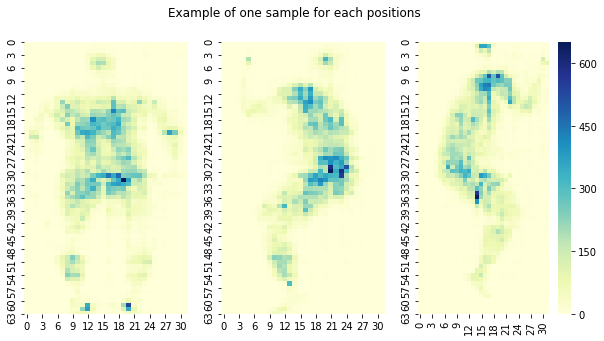

In [3]:
#collecting some examples of data from the first part of the dataset
data_folder = Path("dataset/experiment-i/S3/")

file_name = []
array = []

file_name.append(data_folder / "1.txt")
file_name.append(data_folder / "2.txt")
file_name.append(data_folder / "3.txt")

for i in range(0,len(file_name)):
    df = pd.read_csv(file_name[i], sep="\t", header=None)
    df.drop(columns=[2048], inplace = True) #tolgo colonna
    df.drop(0, inplace = True) #tolgo riga
    df.drop(1, inplace = True) #tolgo riga
    df.drop(2, inplace = True) #tolgo riga
    
    array.append(df.to_numpy())


#plotting one sample for each imported file

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(10,5))
fig.suptitle('Example of one sample for each positions')
g1 = sas.heatmap(np.flip(array[0][1].reshape(64,32),1),cmap="YlGnBu",cbar=False,ax=ax1)
g2 = sas.heatmap(np.flip(array[1][1].reshape(64,32),1),cmap="YlGnBu",cbar=False,ax=ax2)
g3 = sas.heatmap(np.flip(array[2][1].reshape(64,32),1),cmap="YlGnBu",ax=ax3)
plt.show()


In [4]:
PCA_result = []
for i in range(0, len(file_name)):
    print("POSITION", i, "\n")
    tmp = PCA(file_name[i])
    PCA_result.append(rescale(tmp, 1000, 0))
    print("\n")

POSITION 0 

Fraction of the total variability keeping 0 the first principal component:  100.0 %
Fraction of the total variability keeping 1 the first principal component:  100.0 %
Fraction of the total variability keeping 2 the first principal component:  100.0 %
Fraction of the total variability keeping 3 the first principal component:  100.0 %
Fraction of the total variability keeping 4 the first principal component:  100.0 %


POSITION 1 

Fraction of the total variability keeping 0 the first principal component:  100.0 %
Fraction of the total variability keeping 1 the first principal component:  100.0 %
Fraction of the total variability keeping 2 the first principal component:  100.0 %
Fraction of the total variability keeping 3 the first principal component:  100.0 %
Fraction of the total variability keeping 4 the first principal component:  100.0 %


POSITION 2 

Fraction of the total variability keeping 0 the first principal component:  100.0 %
Fraction of the total variability

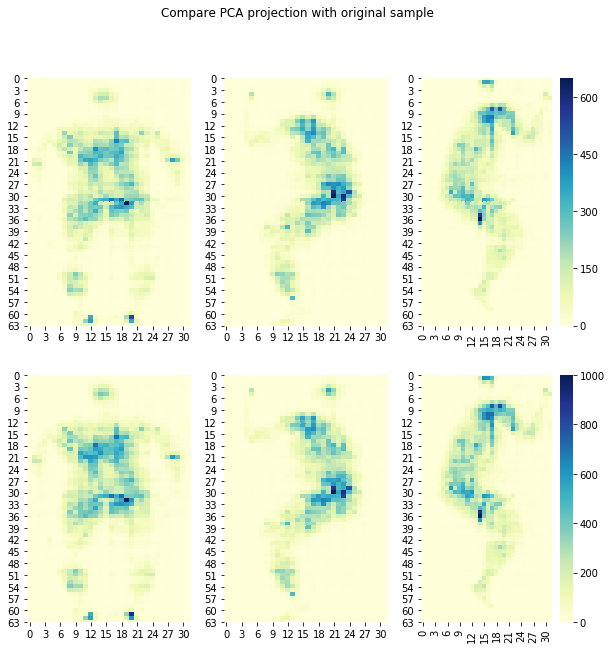

In [5]:
#plot the results of the PCA 

fig, ax = plt.subplots(2, 3, figsize=(10,10))
fig.suptitle('Compare PCA projection with original sample')
g1 = sas.heatmap(np.flip(array[0][1].reshape(64,32),1),cmap="YlGnBu",cbar=False,ax=ax[0,0])
g2 = sas.heatmap(np.flip(array[1][1].reshape(64,32),1),cmap="YlGnBu",cbar=False,ax=ax[0,1])
g3 = sas.heatmap(np.flip(array[2][1].reshape(64,32),1),cmap="YlGnBu",ax=ax[0,2])
g4 = sas.heatmap(np.flip(PCA_result[0].reshape(64,32),1),cmap="YlGnBu",cbar=False,ax=ax[1,0])
g5 = sas.heatmap(np.flip(PCA_result[1].reshape(64,32),1),cmap="YlGnBu",cbar=False,ax=ax[1,1])
g6 = sas.heatmap(np.flip(PCA_result[2].reshape(64,32),1),cmap="YlGnBu",ax=ax[1,2])
plt.show()

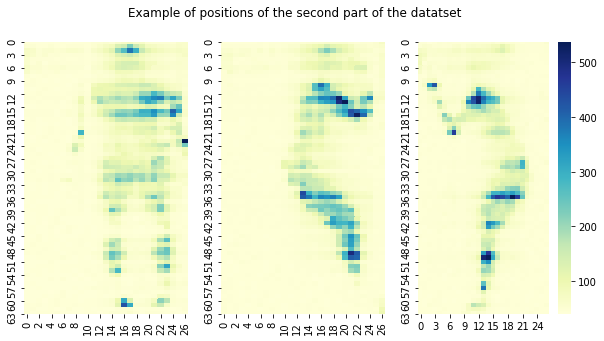

In [6]:
#collecting some examples of data from the second part of the dataset
data_folder = Path("dataset/experiment-ii/S3/Air_Mat/")

file_name = []
array_2 = []

file_name.append(data_folder / "Matrix_Air_B3.txt")
file_name.append(data_folder / "Matrix_Air_D1.txt")
file_name.append(data_folder / "Matrix_Air_C2.txt")

for i in range(0,len(file_name)):
    df = pd.read_csv(file_name[i], sep=" ", header=None)
    
    array_2.append(df.to_numpy())

#plotting one sample for each imported file

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(10,5))
fig.suptitle('Example of positions of the second part of the datatset')
g1 = sas.heatmap(np.flip(array_2[0].reshape(64,27),0),cmap="YlGnBu",cbar=False,ax=ax1)
g2 = sas.heatmap(np.flip(array_2[1].reshape(64,27),0),cmap="YlGnBu",cbar=False,ax=ax2)
g3 = sas.heatmap(np.flip(array_2[2].reshape(64,27),0),cmap="YlGnBu",ax=ax3)
plt.show()

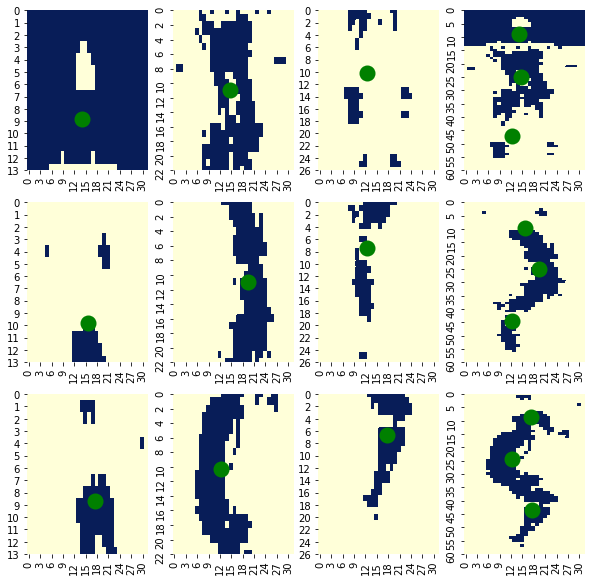

In [11]:
fig, ax = plt.subplots(3, 4, figsize=(10,10))

for i in range(0,len(PCA_result)):
    tmp = np.flip(PCA_result[i].reshape(64,32),1)
    section1 = tmp[:14]
    section2 = tmp[14:37]
    section3 = tmp[37:]
    pos_h_x, pos_h_y, mean_h, labels_1 = kMeans(section1)
    pos_c_x, pos_c_y, mean_c, labels_2 = kMeans(section2)
    pos_l_x, pos_l_y, mean_l, labels_3 = kMeans(section3)
    
    tot = np.concatenate((labels_1, labels_2, labels_3), axis=0)
    
    g1 = sas.heatmap(labels_1.reshape(14,32),cmap="YlGnBu",cbar=False,ax=ax[i,0])
    ax[i,0].scatter(pos_h_x, pos_h_y, marker='o', s=169, linewidths=3, color='g', zorder=10)
    g2 = sas.heatmap(labels_2.reshape(23,32),cmap="YlGnBu",cbar=False,ax=ax[i,1])
    ax[i,1].scatter(pos_c_x, pos_c_y, marker='o', s=169, linewidths=3, color='g', zorder=10)
    g3 = sas.heatmap(labels_3.reshape(27,32),cmap="YlGnBu",cbar=False,ax=ax[i,2])
    ax[i,2].scatter(pos_l_x, pos_l_y, marker='o', s=169, linewidths=3, color='g', zorder=10)
    g4 = sas.heatmap(tot.reshape(64,32),cmap="YlGnBu",cbar=False,ax=ax[i,3])
    ax[i,3].scatter(pos_h_x, pos_h_y, marker='o', s=169, linewidths=3, color='g', zorder=10)
    ax[i,3].scatter(pos_c_x, pos_c_y + 14, marker='o', s=169, linewidths=3, color='g', zorder=10)
    ax[i,3].scatter(pos_l_x, pos_l_y + 37, marker='o', s=169, linewidths=3, color='g', zorder=10)


In [8]:
#load the model
#model_position = load_model('model_position.h5')
#summarize model
#model_position.summary()

with open('test.pkl', 'rb') as f:
    [test_data, test_subject, test_position] = pickle.load(f)

In [9]:
predictions_subject = model_subject.predict(test_data)
predictions_position = model_position.predict(test_data)

predictions_subject = predictions_subject.argmax(axis=-1)
predictions_position = predictions_position.argmax(axis=-1)

labels = ['supine', 'right', 'left']
test_labels = df.iloc[test_split:, num_col-1:num_col]
cm = confusion_matrix(test_labels, predictions_position, [0,1,2])

f,ax= plt.subplots(figsize=(10,10))
sns.heatmap(cm, annot=True, ax = ax, linewidths=1, fmt = 'd', cmap = "Blues"); #annot=True to annotate cells
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix Position'); 
ax.xaxis.set_ticklabels(labels); ax.yaxis.set_ticklabels(labels);

NameError: name 'model_subject' is not defined